# Fit the HSC PSFs with Moffat profiles in multiple bands

In [89]:
import warnings
import numpy as np

from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.table import Table
from astropy import stats

In [3]:
# Matplotlib
# Visualization
import astropy.visualization as vis
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = [10, 10]

In [83]:
def find_center(array):
    return (np.array(array.shape)-1)/2

class FitPSF():
    def __init__(self,band,file_template):
    #Read PSF file
        self.filename = file_template % band
        psf_hdu = fits.open(self.filename)
        psf_data = psf_hdu[0].data
    
        # Generate grid
        self.x, self.y = np.mgrid[:psf_data.shape[0], :psf_data.shape[1]]
        self.z = psf_data
    
    def dofit(self):
        # Fit the data using astropy.modeling
        center_x, center_y = find_center(self.z)
        p_init = models.Moffat2D(x_0=center_x, y_0=center_y)
        fit_p = fitting.LevMarLSQFitter()
        with warnings.catch_warnings():
            # Ignore model linearity warning from the fitter
            warnings.simplefilter('ignore')
            self.model = fit_p(p_init, self.x, self.y, self.z)
        print("Mean Residual:", (self.z - self.model(self.x, self.y)).mean())
        self.params = Table(data=[self.model.param_names, self.model.parameters], names=["param_names", "param_vals"])
        self.gamma = self.model.parameters[3]
        self.alpha = self.model.parameters[4]
        self.fwhm = self.model.fwhm
    
    def plot_results(self):
    # Plot the data with the best-fit model
        vmin, vmax = np.percentile(self.z,1.), np.percentile(self.z,99.)
        print(vmin,vmax)
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(self.z, origin='lower', interpolation='nearest',vmin=vmin,vmax=vmax)
        plt.title("Data")
        plt.subplot(1, 3, 2)
        plt.imshow(self.model(self.x, self.y), origin='lower', interpolation='nearest',vmin=vmin,vmax=vmax)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(100.*(self.z - self.model(self.x, self.y))/self.z, origin='lower', interpolation='nearest',
                   vmin=0,vmax=100.)
        plt.title("Residual in percent")

Mean Residual: -1.7046922612308543e-06
-4.931516775173872e-07 0.012988676393529304
Mean Residual: -1.2415023277010754e-06
-5.562114068940659e-07 0.014622248112221698
Mean Residual: 6.75390625395989e-06
-2.8325690748896946e-06 0.013955710561690551
Mean Residual: 5.2482248559255496e-06
-1.587805816930008e-06 0.014092775896511825
Mean Residual: 4.013167237829612e-06
-1.4717750272810313e-06 0.01343713820513678


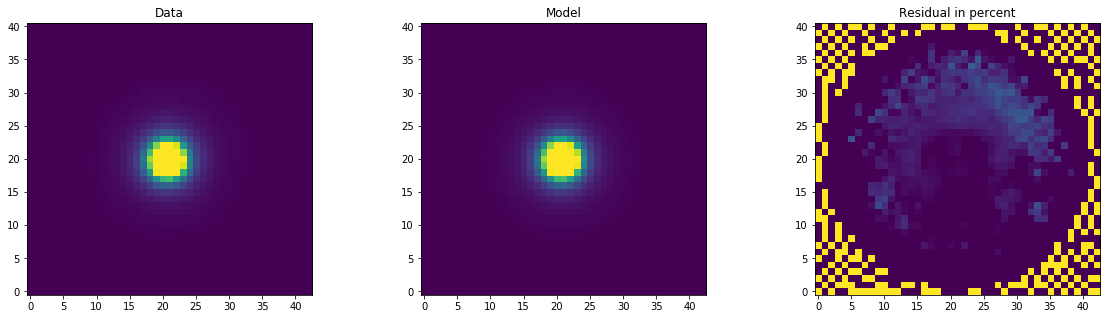

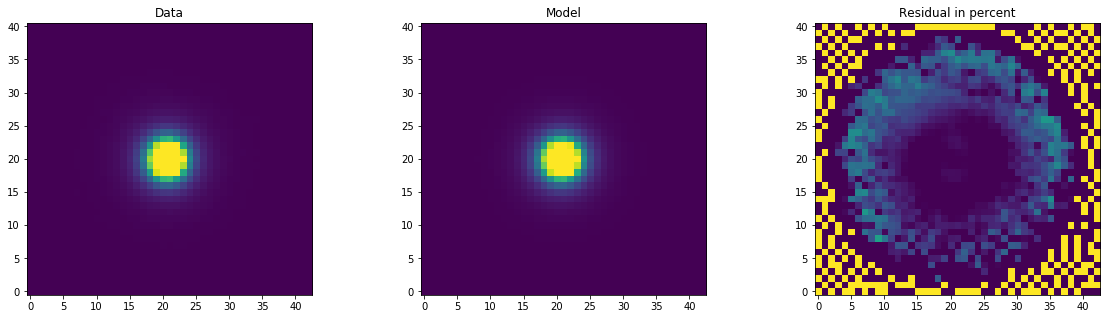

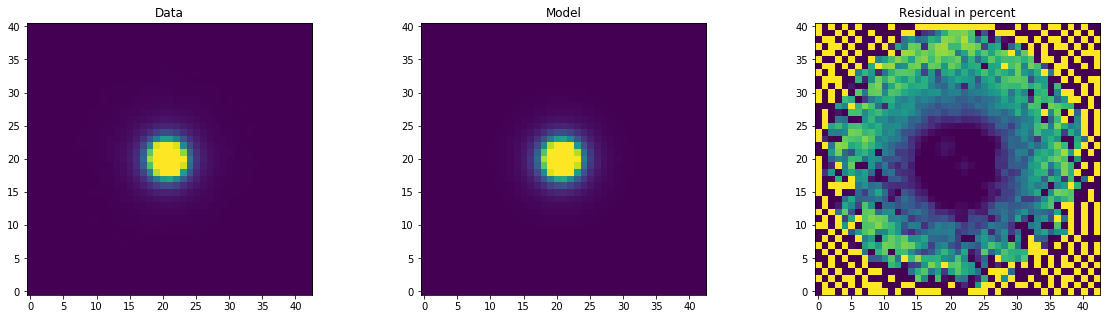

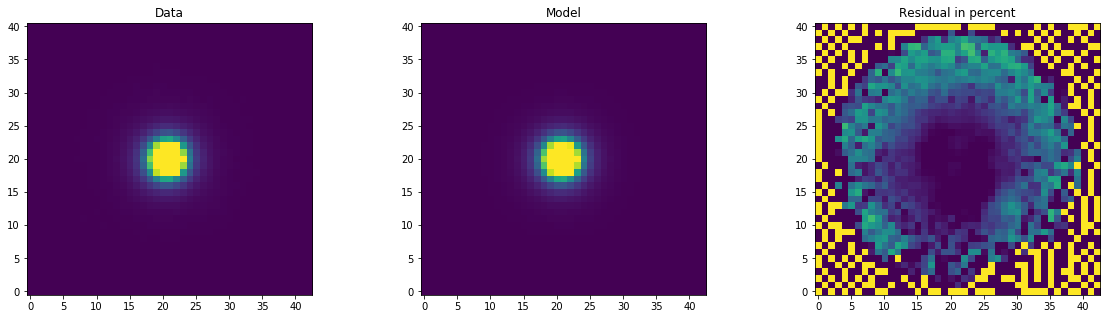

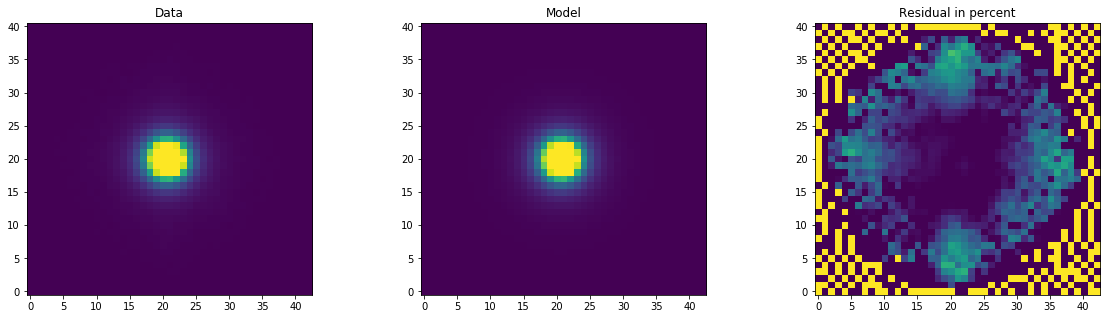

In [84]:
bands = ['G','R','I','Z','Y']
results = Table([np.array([]),np.array([]),np.array([]),np.array([])],names=['band','gamma','alpha','fwhm'],
                dtype=['S2','f4','f4','f4'])
file_template = 'HSC/psf-calexp-pdr2_dud-HSC-%s-17130-3,0-242.84167-53.55806.fits'
for b in bands:
    f = FitPSF(b,file_template)
    f.dofit()
#    print(f.params)
    f.plot_results()
    results.add_row([b,f.gamma,f.alpha,f.fwhm*0.17])

Mean Residual: -1.022699370578594e-05
-2.6380219625891477e-05 0.016615933139675472
Mean Residual: 1.8564765665593435e-05
-5.404715669246543e-05 0.013920517436368287
Mean Residual: -7.836195913372198e-06
-4.137919038322024e-05 0.014231406322720337
Mean Residual: -4.278869413287341e-06
-3.3560827754693555e-05 0.016677409603763394
Mean Residual: 1.9518315956892287e-05
-0.00010329532448310604 0.016140931641601238


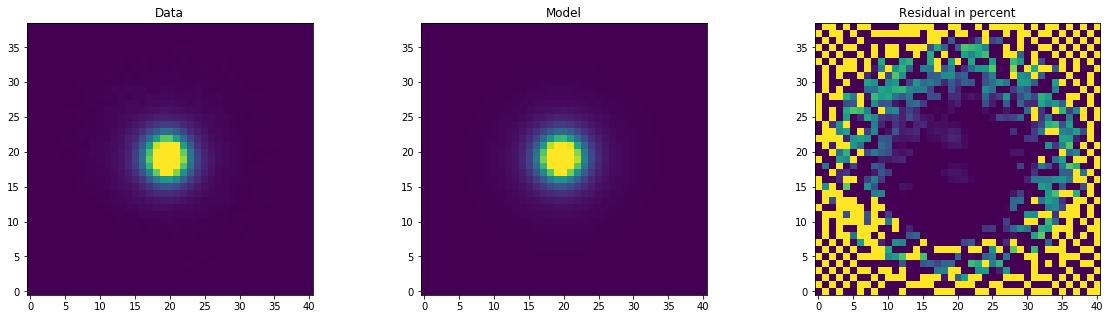

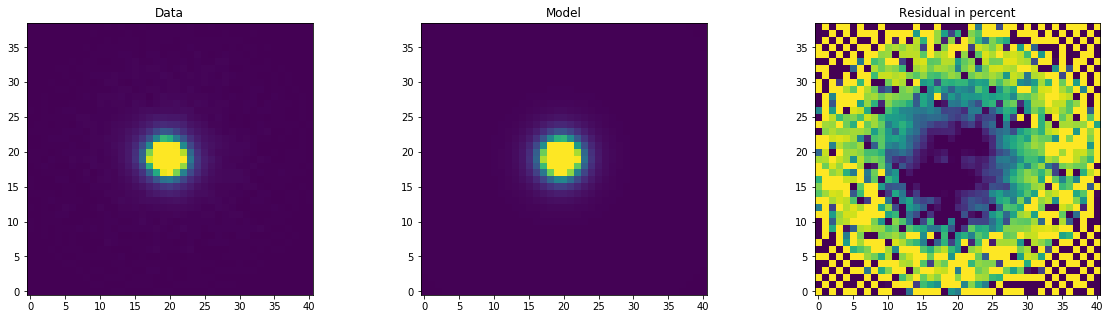

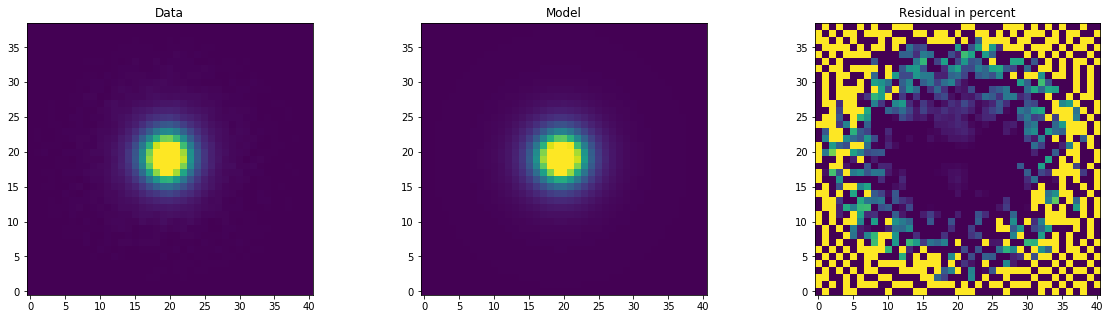

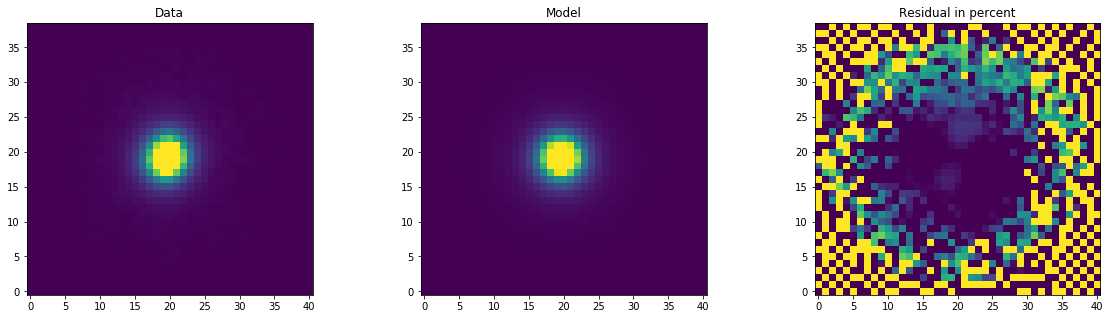

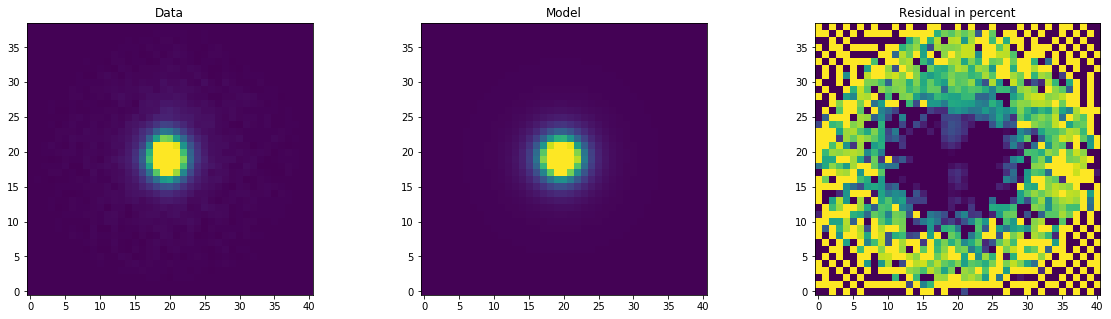

In [85]:
file_template = 'HSC/psf-calexp-s16a_deep-HSC-%s-8283-4,7-35.79583--6.05639.fits'
for b in bands:
    f = FitPSF(b,file_template)
    f.dofit()
#    print(f.params)
    f.plot_results()
    results.add_row([b,f.gamma,f.alpha,f.fwhm*0.17])

In [86]:
results

band,gamma,alpha,fwhm
bytes2,float32,float32,float32
G,2.313742,1.9318289,0.51682365
R,3.3095052,2.398388,0.6513712
I,2.626797,2.5017636,0.5046275
Z,2.5054538,2.230492,0.5142699
Y,2.8020577,2.0709102,0.6006771
G,3.5142097,2.463345,0.68111986
R,2.4802907,2.530051,0.47342774
I,4.515384,2.6125975,0.84623736
Z,3.242879,2.3207102,0.65049976


In [90]:
stats.sigma_clipped_stats(results['alpha'])

(2.358043909072876, 2.4308664798736572, 0.20877452194690704)